# Super Resolution

## Imports and Config

In [1]:
# Disable warnings and info
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from PIL import Image

from data import Images
from models.edsr import edsr

In [4]:
DIR_HIGHRES = './images/original/'
DIR_SPLITS = './images/'
WEIGHTS_DIR = './weights/'
CREATE_FOLDERS = True # Creates folder splits the first time

BATCH_SIZE = 16
FACTOR = 4  # 2-4
INPUT_SIZE = 64 # 256/4
REPEAT_COUNT = 10  # Data Augmentation

# STEPS FOR GAN
STEPS = 300 #200000

LOSS = 'mean_absolute_error'
MODEL_NAME = 'GAN-edsr-x4-fine-tuned'

AUTOTUNE = tf.data.experimental.AUTOTUNE



## Data Preparation

### Splits of high resolution images
Generate splits and obtain dataset of high resolution images

In [ ]:
images = Images(path=DIR_HIGHRES, split_path=DIR_SPLITS)
train_ds, val_ds, test_ds = images.get_high_res_partitions(createFolders=CREATE_FOLDERS)
print(f'High res images: {len(train_ds)} (training), {len(val_ds)} (validation), {len(test_ds)}(test)')

Display some images from train dataset

In [ ]:
plt.figure(figsize=(5, 5))
for i, image in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint32"))
    plt.axis("off")

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
])

if REPEAT_COUNT > 0:
  augmented_train_ds = train_ds.concatenate(train_ds.map(data_augmentation, num_parallel_calls=AUTOTUNE))
  for _ in range(REPEAT_COUNT-1):
      augmented_train_ds = augmented_train_ds.concatenate(train_ds.map(data_augmentation, num_parallel_calls=AUTOTUNE))
  train_ds = augmented_train_ds

In [ ]:
print(f'High res images: {len(train_ds)} (training), {len(val_ds)} (validation), {len(test_ds)}(test)')

In [ ]:
plt.figure(figsize=(5, 5))
for i, image in enumerate(train_ds.skip(1000).take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint32"))
    plt.axis("off")

### Low resolution images
Obtain low resolution image for each high resolution image

In [7]:
# Scales down images using bicubic downsampling.
def downscale_image(image, input_size=INPUT_SIZE):
    return tf.clip_by_value(tf.image.resize(
        image,
        [input_size, input_size],
        method=tf.image.ResizeMethod.BICUBIC,
        antialias=True
    ), 0, 255)

In [ ]:
train_ds = train_ds.map(lambda x: (downscale_image(x), x))
val_ds = val_ds.map(lambda x: (downscale_image(x), x))
test_ds = test_ds.map(lambda x: (downscale_image(x), x))

Display some pairs of images from train dataset with high and low resolutions

In [ ]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(train_ds.take(4)):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(image[1].numpy().astype("uint32"))
    plt.axis("off")
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(image[0].numpy().astype("uint32"))
    plt.axis("off")

### Performance
Improve performance with cache and prefetch

In [ ]:
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

## Training

**Generator:**
Starting from the CNN trained before
**Discriminator:**
A simple CNN as a discriminator

In [13]:
from models import srgan

# Used in content_loss
mean_squared_error = tf.keras.losses.MeanSquaredError()

# Used in generator_loss and discriminator_loss
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Model that computes the feature map after the 4th convolution
# before the 5th max-pooling layer in VGG19. This is layer 20 in
# the corresponding Keras model.
vgg = srgan.vgg_54()

# EDSR model used as generator in SRGAN
generator = edsr(factor=FACTOR, residual_scaling=None)
generator.load_weights(os.path.join(WEIGHTS_DIR, 'weights-edsr-x4-aug-150.h5'))

# SRGAN discriminator
discriminator = srgan.discriminator()

# Optmizers for generator and discriminator.
# TODO: Maybe adjust this
# SRGAN will be trained for
# 10,000 steps and learning rate is reduced from 1e-4 to 1e-5 after
# 5,000 steps
schedule = PiecewiseConstantDecay(boundaries=[5000], values=[1e-4, 1e-5])
generator_optimizer = Adam(learning_rate=schedule)
discriminator_optimizer = Adam(learning_rate=schedule)

def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

@tf.function
def content_loss(hr, sr):
    sr = tf.keras.applications.vgg19.preprocess_input(sr)
    hr = tf.keras.applications.vgg19.preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

@tf.function
def train_step(lr, hr):
    """SRGAN training step.

    Takes an LR and an HR image batch as input and returns
    the computed perceptual loss and discriminator loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        # Forward pass
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        # Compute losses
        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    # Compute gradient of perceptual loss w.r.t. generator weights
    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    # Compute gradient of discriminator loss w.r.t. discriminator weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return perc_loss, disc_loss

pls_metric = tf.keras.metrics.Mean()
dls_metric = tf.keras.metrics.Mean()

step = 0

# Train SRGAN for 'STEPS' steps.
for lr, hr in train_ds.take(STEPS):
    step += 1

    pl, dl = train_step(lr, hr)
    pls_metric(pl)
    dls_metric(dl)

    if step % 50 == 0:
        print(f'{step}/{STEPS}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
        pls_metric.reset_states()
        dls_metric.reset_states()

generator.save_weights(os.path.join(WEIGHTS_DIR, f'weights-{MODEL_NAME}.h5'))


50/300, perceptual loss = 0.0721, discriminator loss = 3.5306
100/300, perceptual loss = 0.0479, discriminator loss = 1.9915
150/300, perceptual loss = 0.0495, discriminator loss = 1.7366
200/300, perceptual loss = 0.0630, discriminator loss = 1.4429
250/300, perceptual loss = 0.0676, discriminator loss = 1.1817
300/300, perceptual loss = 0.0699, discriminator loss = 1.8494


## Evaluation

In [8]:
edsr_pre_trained = edsr(factor=FACTOR, residual_scaling=None)
edsr_pre_trained.load_weights(os.path.join(WEIGHTS_DIR, f'weights-{MODEL_NAME}.h5'))

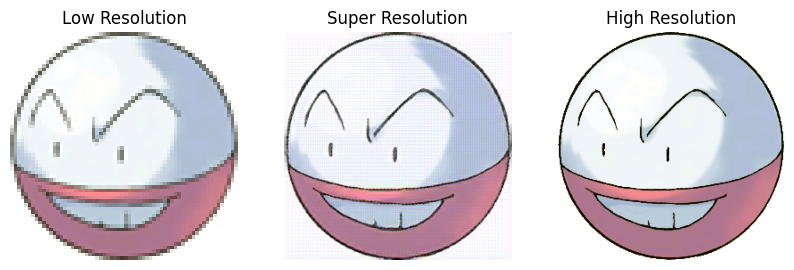

In [9]:
hr = tf.convert_to_tensor(Image.open('../images/test/hr/101.jpg'))
lr = downscale_image(hr)
lr_batch = tf.expand_dims(lr, axis=0)
sr = edsr_pre_trained(lr_batch)[0]
sr = tf.clip_by_value(sr, 0, 255)

images = [lr, sr, hr]
titles = ["Low Resolution", "Super Resolution", "High Resolution"]

plt.figure(figsize=(10,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(title)
    plt.axis("off")
plt.show()